# EE541 Final Project – CNN Baseline with Operating Conditions

# 0: unzip CMAPSS, imports, global config

In [1]:
import os
import zipfile
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Automatically extract the CMAPSS dataset if the folder does not exist yet.
# The zip file should be placed in the same directory as this notebook.
DATA_ZIP = "CMAPSSData.zip"
DATA_ROOT = "CMAPSSData"

print("Zip exists?", os.path.exists(DATA_ZIP), "->", DATA_ZIP)
if not os.path.isdir(DATA_ROOT):
    print(f"Unzipping {DATA_ZIP} to {DATA_ROOT} ...")
    with zipfile.ZipFile(DATA_ZIP, "r") as zf:
        zf.extractall(DATA_ROOT)
else:
    print(f"Folder {DATA_ROOT} already exists, skip unzip.")

print("\nFiles inside", DATA_ROOT, ":")
for name in os.listdir(DATA_ROOT):
    print(" -", name)


# Choose GPU when available (recommended for model training).
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


# Fix all random seeds for reproducibility across runs.
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)


# Supported datasets: the four standard subsets in NASA C-MAPSS.
DATASETS = ["FD001", "FD002", "FD003", "FD004"]

# Window sizes for sliding-window time-series modeling.
WINDOWS = [35, 50]

# Loss functions to compare (MSE, MAE, and NASA score).
LOSS_TYPES = ["mse", "mae", "nasa"]

# Training hyperparameters (kept identical to LSTM version for fair comparison).
EPOCHS = 20
BATCH_SIZE = 64
LR = 1e-3
CLIP_RUL = 125    # PHM Competition rule: clip remaining cycles to 125


# Each time step contains 3 operating condition variables + 21 sensor readings.
FEATURE_COLS = ["op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]
N_FEATURES = len(FEATURE_COLS)

print("Feature columns:", FEATURE_COLS)
print("Number of features:", N_FEATURES)


# Dataset location for Colab use. Can be modified when running locally.
DATA_ROOT = "/content/CMAPSSData"
print("DATA_ROOT =", DATA_ROOT)

Zip exists? True -> CMAPSSData.zip
Unzipping CMAPSSData.zip to CMAPSSData ...

Files inside CMAPSSData :
 - train_FD003.txt
 - Damage Propagation Modeling.pdf
 - train_FD004.txt
 - test_FD004.txt
 - test_FD001.txt
 - RUL_FD001.txt
 - test_FD003.txt
 - test_FD002.txt
 - readme.txt
 - RUL_FD004.txt
 - train_FD002.txt
 - RUL_FD002.txt
 - train_FD001.txt
 - RUL_FD003.txt
Using device: cuda
Feature columns: ['op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Number of features: 24
DATA_ROOT = /content/CMAPSSData


# 1: load CMAPSS FD00x data (train/test/RUL)

In [2]:
# raw columns: 2 id + 3 ops + 21 sensors = 26 cols
ALL_COLS = ["unit", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1, 22)]

print("All columns:", ALL_COLS)
print("Feature columns:", FEATURE_COLS)

def load_fd(fd_name: str):
    #Load one CMAPSS subset (FD001–FD004) including its train set, test set, and the ground-truth RUL labels for test engines.

    # Ensure a valid subset name is provided.
    assert fd_name in ["FD001", "FD002", "FD003", "FD004"]

    # Construct file paths based on dataset name.
    train_path = os.path.join(DATA_ROOT, f"train_{fd_name}.txt")
    test_path  = os.path.join(DATA_ROOT, f"test_{fd_name}.txt")
    rul_path   = os.path.join(DATA_ROOT, f"RUL_{fd_name}.txt")

    print(f"\nLoading {fd_name} ...")
    print("  train:", train_path)
    print("  test :", test_path)
    print("  RUL  :", rul_path)

    # Raw CMAPSS txt files
    train_df = pd.read_csv(train_path, sep=r"\s+", header=None)
    train_df.columns = ALL_COLS

    test_df = pd.read_csv(test_path, sep=r"\s+", header=None)
    test_df.columns = ALL_COLS

    # RUL file only contains a single column.
    rul_df = pd.read_csv(rul_path, sep=r"\s+", header=None)
    rul_df.columns = ["RUL"]

    return train_df, test_df, rul_df


# quick check on FD001
train_fd001, test_fd001, rul_fd001 = load_fd("FD001")

print("\nTrain FD001 head():")
display(train_fd001.head())

print("\nRUL FD001 head():")
display(rul_fd001.head())

DATA_ROOT = /content/CMAPSSData
All columns: ['unit', 'cycle', 'op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Feature columns: ['op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

Loading FD001 ...
  train: /content/CMAPSSData/train_FD001.txt
  test : /content/CMAPSSData/test_FD001.txt
  RUL  : /content/CMAPSSData/RUL_FD001.txt
  train shape: (20631, 26), test shape: (13096, 26), RUL shape: (100, 1)
  train units: 100, test units: 100

Train FD001 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044



RUL FD001 head():


,RUL
0,112
1,98
2,69
3,82
4,91


# 2: split train/val and global normalization helpers

In [3]:
# Split engines into train/val sets by unit ID
def split_train_val_by_unit(train_df, val_ratio=0.2):
    #Split by engine id (unit).
    units = sorted(train_df["unit"].unique())
    n_units = len(units)
    n_val = int(n_units * val_ratio)
    val_units = units[-n_val:]
    train_units = units[:-n_val]

    train80 = train_df[train_df["unit"].isin(train_units)].reset_index(drop=True)
    val20 = train_df[train_df["unit"].isin(val_units)].reset_index(drop=True)

    print(f"Total units: {n_units}, train: {len(train_units)}, val: {len(val_units)}")
    print("train80 shape:", train80.shape, "val20 shape:", val20.shape)
    return train80, val20

# Compute a single mean/std from training data for feature normalization.
def compute_global_stats(train_df, feature_cols):
    #Mean/std over all train80 rows.
    mean = train_df[feature_cols].mean()
    std = train_df[feature_cols].std()
    std = std.replace(0.0, 1.0)
    return {"mean": mean, "std": std}

# Apply global normalization so all features share a consistent scale.
def normalize_global(df, feature_cols, stats):
    #Normalize using one global mean/std.
    df = df.copy()
    mean = stats["mean"]
    std = stats["std"]
    df[feature_cols] = (df[feature_cols] - mean) / std
    return df


# apply to FD001 to check
train80_fd001, val20_fd001 = split_train_val_by_unit(train_fd001, val_ratio=0.2)
global_stats_fd001 = compute_global_stats(train80_fd001, FEATURE_COLS)

train80_fd001_norm = normalize_global(train80_fd001, FEATURE_COLS, global_stats_fd001)
val20_fd001_norm   = normalize_global(val20_fd001, FEATURE_COLS, global_stats_fd001)

print("\nNormalized train80 FD001 head():")
display(train80_fd001_norm.head())

Total units: 100, train: 80, val: 20
train80 shape: (16138, 26) val20 shape: (4493, 26)

Normalized train80 FD001 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.324464,-1.361174,0.0,0.0,-1.731084,-0.143899,-0.939474,-0.001167,...,0.344842,-1.056928,-0.269290,-0.615160,-0.001128,-0.792175,0.0,0.0,1.357272,1.201121
1,1,2,0.863734,-1.020933,0.0,0.0,-1.072021,0.201943,-0.656531,-0.001167,...,1.184663,-0.368258,-0.630644,-0.287331,-0.001128,-0.792175,0.0,0.0,1.025859,1.243476
2,1,3,-1.969661,1.020511,0.0,0.0,-0.672589,-0.422857,-0.538453,-0.001167,...,1.374301,-0.919194,-0.542460,-0.660469,-0.001128,-2.083305,0.0,0.0,0.749681,0.512390
3,1,4,0.315335,-0.000211,0.0,0.0,-0.672589,-1.271150,-0.798003,-0.001167,...,1.970303,-0.230524,-0.512051,-1.982444,-0.001128,-0.792175,0.0,0.0,0.363032,0.785857
4,1,5,-0.872863,-0.680692,0.0,0.0,-0.632646,-1.261362,-0.313435,-0.001167,...,1.062754,-0.781460,-0.513571,-0.351298,-0.001128,-0.146610,0.0,0.0,0.473503,1.066689


# 3: RUL column + sliding-window Dataset

In [4]:
def add_rul_column(df, clip_rul=CLIP_RUL):
    #Add RUL for each row, clipped at clip_rul.
    df = df.copy()
    max_cycle = df.groupby("unit")["cycle"].transform("max")
    df["RUL"] = max_cycle - df["cycle"]
    df["RUL"] = df["RUL"].clip(upper=clip_rul)
    return df


class CmapssTrainDataset(Dataset):
    #Sliding windows for train/val.

    def __init__(self, df, window, feature_cols, clip_rul=CLIP_RUL):
        self.window = window
        self.feature_cols = feature_cols

        df = df.sort_values(["unit", "cycle"])
        df = add_rul_column(df, clip_rul)

        X_list = []
        y_list = []

        for unit_id, g in df.groupby("unit"):
            data = g[feature_cols].values  # (T, F)
            rul  = g["RUL"].values        # (T,)

            for t in range(window - 1, len(g)):
                x_win = data[t - window + 1 : t + 1]  # (w, F)
                y_t   = rul[t]                        # scalar
                X_list.append(x_win)
                y_list.append(y_t)

        self.X = np.array(X_list, dtype=np.float32)   # (N, w, F)
        self.y = np.array(y_list, dtype=np.float32)   # (N,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])                      # (w, F)
        y = torch.tensor(self.y[idx], dtype=torch.float32)     # scalar tensor
        return x, y


# quick test on FD001, window = 35
window = 35
train_ds_fd001 = CmapssTrainDataset(train80_fd001_norm, window, FEATURE_COLS, CLIP_RUL)
val_ds_fd001   = CmapssTrainDataset(val20_fd001_norm,   window, FEATURE_COLS, CLIP_RUL)

print("Train dataset size:", len(train_ds_fd001))
print("Val dataset size:", len(val_ds_fd001))

x0, y0 = train_ds_fd001[0]
print("One sample x shape:", x0.shape)  # expect (35, 24)
print("One sample y:", y0, "shape:", y0.shape)

Train dataset size: 13418
Val dataset size: 3813
One sample x shape: torch.Size([35, 24])
One sample y: tensor(125.) shape: torch.Size([])


# 4: CNN model (1D, 3 conv, 24-dim input)

In [5]:
class CNNBaseline(nn.Module):
    """
    1D CNN baseline using 24-dim input (op1, op2, op3, s1..s21).
    Input:  x (B, w, 24)
    Internally: (B, 24, w) -> Conv1d -> ...
    """
    def __init__(self, fc_hidden=64):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=24, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()

        # Maximal final length when w=50: 50 / 2 / 2 / 2 = 6.25 -> 6
        # So we build FC with 128 * 6, and for w=35 (-> 4) we will slice/pad inside forward.
        self.fc_hidden = fc_hidden
        self.fc_in_dim = 128 * 6

        self.fc1 = nn.Linear(self.fc_in_dim, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, 1)

    def forward(self, x):
        # x: (B, w, 24)
        x = x.permute(0, 2, 1)  # (B, 24, w)

        x = self.pool(self.relu(self.conv1(x)))  # (B,32,w/2)
        x = self.pool(self.relu(self.conv2(x)))  # (B,64,w/4)
        x = self.pool(self.relu(self.conv3(x)))  # (B,128,w/8)

        # adapt to either length 4 (w=35) or 6 (w=50)
        B, C, T = x.shape  # C=128, T is 4 or 6
        if T > 6:
            x = x[:, :, :6]
            T = 6
        elif T < 6:
            # simple right-padding with zeros
            pad = torch.zeros(B, C, 6 - T, device=x.device, dtype=x.dtype)
            x = torch.cat([x, pad], dim=2)
            T = 6

        x = x.reshape(B, C * T)  # (B, 128 * 6)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)


# quick forward test
window = 35
train_loader_fd001 = DataLoader(train_ds_fd001, batch_size=BATCH_SIZE, shuffle=True)
batch_x, batch_y = next(iter(train_loader_fd001))
print("batch_x shape:", batch_x.shape)
print("batch_y shape:", batch_y.shape)

model = CNNBaseline().to(DEVICE)
batch_x = batch_x.to(DEVICE)
y_pred = model(batch_x)
print("y_pred shape:", y_pred.shape)

batch_x shape: torch.Size([64, 35, 24])
batch_y shape: torch.Size([64])
y_pred shape: torch.Size([64])


# 5: loss, metrics, simple train loop helpers


In [6]:
def nasa_score_np(y_true, y_pred):
    """NASA score"""
    e = y_pred - y_true
    score = 0.0
    for err in e:
        if err < 0:
            score += np.exp(-err / 13.0) - 1.0
        else:
            score += np.exp(err / 10.0) - 1.0
    return score

def get_loss_fn(name):
    """Return loss function by name."""
    name = name.lower()
    if name == "mse":
        return nn.MSELoss()
    elif name == "mae":
        return nn.L1Loss()
    elif name == "nasa":
        # use mean NASA score as loss
        def nasa_loss(pred, target):
            return torch.tensor(
                nasa_score_np(target.cpu().numpy(), pred.cpu().numpy()) / len(pred),
                dtype=torch.float32,
                device=pred.device,
            )
        return nasa_loss
    else:
        raise ValueError(f"Unknown loss type: {name}")

def evaluate(model, data_loader):
    """Compute MSE, RMSE, MAE, NASA on a loader."""
    model.eval()
    all_true = []
    all_pred = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x)
            all_true.append(y.cpu().numpy())
            all_pred.append(pred.cpu().numpy())
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    mse  = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(y_pred - y_true))
    nasa = nasa_score_np(y_true, y_pred)
    return mse, rmse, mae, nasa

# 6: simple FD001 train loop test (w=35, MSE)

In [7]:

window = 35
loss_type = "mse"

train_ds_fd001 = CmapssTrainDataset(train80_fd001_norm, window, FEATURE_COLS, CLIP_RUL)
val_ds_fd001   = CmapssTrainDataset(val20_fd001_norm,   window, FEATURE_COLS, CLIP_RUL)

train_loader = DataLoader(train_ds_fd001, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds_fd001,   batch_size=BATCH_SIZE, shuffle=False)

model = CNNBaseline().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = get_loss_fn(loss_type)

print(f"Train FD001 CNN, w={window}, loss={loss_type}, epochs={EPOCHS}")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    val_mse, val_rmse, val_mae, val_nasa = evaluate(model, val_loader)

    print(
        f"Epoch {epoch:02d} "
        f"| train_loss={avg_train_loss:.4f} "
        f"| val_rmse={val_rmse:.3f} "
        f"| val_mae={val_mae:.3f} "
        f"| val_nasa={val_nasa:.1f}"
    )

Train FD001 CNN, w=35, loss=mse, epochs=20
Epoch 01 | train_loss=1324.6007 | val_rmse=23.731 | val_mae=19.195 | val_nasa=68965.4
Epoch 02 | train_loss=417.6105 | val_rmse=21.900 | val_mae=17.074 | val_nasa=54351.0
Epoch 03 | train_loss=304.4970 | val_rmse=18.603 | val_mae=14.518 | val_nasa=23787.8
Epoch 04 | train_loss=198.6733 | val_rmse=16.518 | val_mae=13.062 | val_nasa=15992.3
Epoch 05 | train_loss=168.6143 | val_rmse=17.070 | val_mae=13.465 | val_nasa=14449.3
Epoch 06 | train_loss=143.7571 | val_rmse=16.242 | val_mae=12.996 | val_nasa=13440.9
Epoch 07 | train_loss=125.9470 | val_rmse=16.156 | val_mae=12.872 | val_nasa=13548.5
Epoch 08 | train_loss=119.9431 | val_rmse=16.321 | val_mae=12.773 | val_nasa=13899.2
Epoch 09 | train_loss=109.7604 | val_rmse=16.429 | val_mae=12.774 | val_nasa=14125.9
Epoch 10 | train_loss=95.8000 | val_rmse=16.296 | val_mae=12.970 | val_nasa=14597.4
Epoch 11 | train_loss=89.2800 | val_rmse=16.178 | val_mae=12.595 | val_nasa=15071.2
Epoch 12 | train_loss=7

# 7: FD001 train helper with history and best model

In [8]:

def run_fd001(window, loss_type="mse", save_model=False):
    print(f"\n===== FD001 | w={window} | loss={loss_type} | epochs={EPOCHS} =====")

    # Build sliding-window datasets for FD001 (train/val).
    train_ds = CmapssTrainDataset(train80_fd001_norm, window, FEATURE_COLS, CLIP_RUL)
    val_ds   = CmapssTrainDataset(val20_fd001_norm,   window, FEATURE_COLS, CLIP_RUL)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize CNN model with shared hyperparameters.
    model = CNNBaseline().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = get_loss_fn(loss_type)

    history = []
    best_rmse = float("inf")   # Track best model by validation RMSE.
    best_info = None
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_losses = []

        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Evaluate on validation set for generalization performance.
        val_mse, val_rmse, val_mae, val_nasa = evaluate(model, val_loader)

        history.append({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_mse": val_mse,
            "val_rmse": val_rmse,
            "val_mae": val_mae,
            "val_nasa": val_nasa,
        })

        # Save best model checkpoint based on RMSE.
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_info = {
                "epoch": epoch,
                "mse": val_mse,
                "rmse": val_rmse,
                "mae": val_mae,
                "nasa": val_nasa,
            }
            best_state = model.state_dict()


        print(
            f"Epoch {epoch:02d} "
            f"| train_loss={avg_train_loss:.4f} "
            f"| val_rmse={val_rmse:.3f} "
            f"| val_mae={val_mae:.3f} "
            f"| val_nasa={val_nasa:.1f}"
        )

    print("\nBest epoch (by val RMSE):", best_info["epoch"])
    print(f"  MSE  = {best_info['mse']:.3f}")
    print(f"  RMSE = {best_info['rmse']:.3f}")
    print(f"  MAE  = {best_info['mae']:.3f}")
    print(f"  NASA = {best_info['nasa']:.1f}")

    best_path = None
    if save_model and best_state is not None:
        best_path = f"cnn_fd001_w{window}_{loss_type}.pt"
        torch.save(best_state, best_path)
        print("Saved best model to:", best_path)

    return history, best_info, best_path


# run FD001 for w = 35 and 50 (MSE)
hist_fd001 = {}
best_fd001 = {}
path_fd001 = {}

for w in WINDOWS:
    hist, best, path = run_fd001(w, loss_type="mse", save_model=True)
    hist_fd001[w] = hist
    best_fd001[w] = best
    path_fd001[w] = path

print("\nBest FD001 CNN results (MSE):")
for w in WINDOWS:
    b = best_fd001[w]
    print(f"w={w}: epoch={b['epoch']}, RMSE={b['rmse']:.3f}, MAE={b['mae']:.3f}, NASA={b['nasa']:.1f}")

df_35 = pd.DataFrame(hist_fd001[35])
display(df_35.head())


===== FD001 | w=35 | loss=mse | epochs=20 =====
Epoch 01 | train_loss=1185.0975 | val_rmse=24.397 | val_mae=19.879 | val_nasa=65448.2
Epoch 02 | train_loss=487.5163 | val_rmse=22.230 | val_mae=17.342 | val_nasa=66741.9
Epoch 03 | train_loss=348.1088 | val_rmse=20.175 | val_mae=15.407 | val_nasa=48208.9
Epoch 04 | train_loss=245.2333 | val_rmse=18.653 | val_mae=14.698 | val_nasa=17518.8
Epoch 05 | train_loss=190.6990 | val_rmse=15.770 | val_mae=12.171 | val_nasa=17500.4
Epoch 06 | train_loss=161.0935 | val_rmse=16.330 | val_mae=12.453 | val_nasa=21218.0
Epoch 07 | train_loss=143.3305 | val_rmse=16.832 | val_mae=13.283 | val_nasa=13785.6
Epoch 08 | train_loss=130.5043 | val_rmse=15.301 | val_mae=12.021 | val_nasa=13892.9
Epoch 09 | train_loss=116.2742 | val_rmse=15.333 | val_mae=12.107 | val_nasa=12425.8
Epoch 10 | train_loss=108.2446 | val_rmse=15.546 | val_mae=12.243 | val_nasa=12639.0
Epoch 11 | train_loss=99.1727 | val_rmse=16.767 | val_mae=13.255 | val_nasa=14418.8
Epoch 12 | train

,epoch,train_loss,val_mse,val_rmse,val_mae,val_nasa
0,1,1185.097502,595.233459,24.397408,19.879475,65448.218750
1,2,487.516259,494.180389,22.230169,17.342045,66741.867188
2,3,348.108824,407.019257,20.174719,15.406518,48208.933594
3,4,245.233303,347.936035,18.653044,14.697577,17518.810547
4,5,190.698976,248.700165,15.770230,12.171450,17500.382812


# 8: generic train helper + FD003 (global normalization)

In [9]:
def run_cnn_dataset(name, train_df_norm, val_df_norm,
                    window, loss_type="mse", save_model=False):
    print(f"\n===== {name} | w={window} | loss={loss_type} | epochs={EPOCHS} =====")

    # Sliding-window datasets based on the selected window size.
    train_ds = CmapssTrainDataset(train_df_norm, window, FEATURE_COLS, CLIP_RUL)
    val_ds   = CmapssTrainDataset(val_df_norm,   window, FEATURE_COLS, CLIP_RUL)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # CNN model with identical hyperparameters as LSTM for fair comparison.
    model = CNNBaseline().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = get_loss_fn(loss_type)

    history = []
    best_rmse = float("inf")   # Track checkpoint with best validation RMSE.
    best_info = None
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_losses = []

        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Validation metrics to measure generalization.
        val_mse, val_rmse, val_mae, val_nasa = evaluate(model, val_loader)

        history.append({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_mse": val_mse,
            "val_rmse": val_rmse,
            "val_mae": val_mae,
            "val_nasa": val_nasa,
        })

        # Update best checkpoint if RMSE improves.
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_info = {
                "epoch": epoch,
                "mse": val_mse,
                "rmse": val_rmse,
                "mae": val_mae,
                "nasa": val_nasa,
            }
            best_state = model.state_dict()

        print(
            f"Epoch {epoch:02d} "
            f"| train_loss={avg_train_loss:.4f} "
            f"| val_rmse={val_rmse:.3f} "
            f"| val_mae={val_mae:.3f} "
            f"| val_nasa={val_nasa:.1f}"
        )

    print("\nBest epoch (by val RMSE):", best_info["epoch"])
    print(f"  MSE  = {best_info['mse']:.3f}")
    print(f"  RMSE = {best_info['rmse']:.3f}")
    print(f"  MAE  = {best_info['mae']:.3f}")
    print(f"  NASA = {best_info['nasa']:.1f}")

    best_path = None
    if save_model and best_state is not None:
        # Save only the best-performing model weights.
        best_path = f"cnn_{name.lower()}_w{window}_{loss_type}.pt"
        torch.save(best_state, best_path)
        print("Saved best model to:", best_path)

    return history, best_info, best_path



# FD003: load + split + global norm + run
train_fd003, test_fd003, rul_fd003 = load_fd("FD003")
train80_fd003, val20_fd003 = split_train_val_by_unit(train_fd003, val_ratio=0.2)

global_stats_fd003 = compute_global_stats(train80_fd003, FEATURE_COLS)
train80_fd003_norm = normalize_global(train80_fd003, FEATURE_COLS, global_stats_fd003)
val20_fd003_norm   = normalize_global(val20_fd003,  FEATURE_COLS, global_stats_fd003)

print("\nNormalized train80 FD003 head():")
display(train80_fd003_norm.head())

hist_fd003 = {}
best_fd003 = {}
path_fd003 = {}

for w in WINDOWS:
    hist, best, path = run_cnn_dataset("FD003",
                                       train80_fd003_norm,
                                       val20_fd003_norm,
                                       window=w,
                                       loss_type="mse",
                                       save_model=True)
    hist_fd003[w] = hist
    best_fd003[w] = best
    path_fd003[w] = path

print("\nBest FD003 CNN results (MSE):")
for w in WINDOWS:
    b = best_fd003[w]
    print(f"w={w}: epoch={b['epoch']}, RMSE={b['rmse']:.3f}, MAE={b['mae']:.3f}, NASA={b['nasa']:.1f}")


Loading FD003 ...
  train: /content/CMAPSSData/train_FD003.txt
  test : /content/CMAPSSData/test_FD003.txt
  RUL  : /content/CMAPSSData/RUL_FD003.txt
  train shape: (24720, 26), test shape: (16596, 26), RUL shape: (100, 1)
  train units: 100, test units: 100
Total units: 100, train: 80, val: 20
train80 shape: (19779, 26) val20 shape: (4941, 26)

Normalized train80 FD003 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.213354,1.328201,0.0,0.0,-0.182950,-0.693397,-0.767430,-0.001064,...,-0.174413,-0.333028,0.093161,0.426725,-0.000922,-0.863748,0.0,0.0,0.541181,-0.218666
1,1,2,0.380616,-1.048758,0.0,0.0,0.082622,-0.481132,-0.762376,-0.001064,...,-0.140034,-0.211679,0.536983,0.689608,-0.000922,-0.302953,0.0,0.0,0.054681,0.427331
2,1,3,-0.624565,-0.709192,0.0,0.0,-0.524400,-0.821338,0.119102,-0.001064,...,-0.261921,-0.393703,0.379022,-0.150950,-0.000922,-0.863748,0.0,0.0,-0.512902,-0.129283
3,1,4,-0.898705,0.309504,0.0,0.0,0.879339,-0.347376,-1.229398,-0.001064,...,-0.118157,0.091695,0.166247,-0.189462,-0.000922,-0.302953,0.0,0.0,-0.066944,-0.615474
4,1,5,0.746137,-0.030061,0.0,0.0,-1.472873,0.091693,-0.685550,-0.001064,...,-0.090030,-0.211679,0.239334,-0.204531,-0.000922,-0.302953,0.0,0.0,0.662806,0.489628



===== FD003 | w=35 | loss=mse | epochs=20 =====
Epoch 01 | train_loss=1174.9789 | val_rmse=22.474 | val_mae=18.192 | val_nasa=45324.9
Epoch 02 | train_loss=376.0398 | val_rmse=21.332 | val_mae=17.216 | val_nasa=39321.6
Epoch 03 | train_loss=293.2584 | val_rmse=19.303 | val_mae=15.938 | val_nasa=23516.1
Epoch 04 | train_loss=201.9861 | val_rmse=15.754 | val_mae=12.163 | val_nasa=19444.6
Epoch 05 | train_loss=148.0676 | val_rmse=15.291 | val_mae=11.633 | val_nasa=18463.9
Epoch 06 | train_loss=120.7040 | val_rmse=16.427 | val_mae=12.467 | val_nasa=21903.6
Epoch 07 | train_loss=100.7341 | val_rmse=14.891 | val_mae=11.655 | val_nasa=15893.7
Epoch 08 | train_loss=89.5954 | val_rmse=16.412 | val_mae=12.979 | val_nasa=18295.4
Epoch 09 | train_loss=79.4255 | val_rmse=16.273 | val_mae=12.036 | val_nasa=26183.7
Epoch 10 | train_loss=70.1110 | val_rmse=16.983 | val_mae=12.701 | val_nasa=31605.2
Epoch 11 | train_loss=60.3863 | val_rmse=16.475 | val_mae=12.220 | val_nasa=20709.1
Epoch 12 | train_lo

# 9: data prep helpers for multi-condition datasets (FD002 / FD004)

In [10]:
# Cluster operating conditions (op1/op2/op3) into cond_id for multi-condition modeling.
def add_kmeans_cond_id(train_df, val_df, n_cond=6, random_state=0):
    train_df = train_df.copy()
    val_df   = val_df.copy()

    kmeans = KMeans(n_clusters=n_cond, random_state=random_state, n_init=10)

    train_ops = train_df[["op1", "op2", "op3"]].values
    val_ops   = val_df[["op1", "op2", "op3"]].values

    train_df["cond_id"] = kmeans.fit_predict(train_ops)
    val_df["cond_id"]   = kmeans.predict(val_ops)

    print("Found conditions in train:", sorted(train_df["cond_id"].unique()))
    return train_df, val_df, kmeans


# Compute separate mean/std per operating condition for normalization.
def compute_cond_stats_by_id(df, feature_cols):
    stats = {}
    for cid, g in df.groupby("cond_id"):
        mean = g[feature_cols].mean().astype("float32")
        std  = g[feature_cols].std().replace(0.0, 1.0).astype("float32")
        stats[cid] = {"mean": mean, "std": std}
    print("Number of conditions in train:", len(stats))
    return stats


# Normalize each sample using statistics of its assigned condition.
def normalize_by_condid(df, feature_cols, cond_stats):
    df = df.copy()
    df[feature_cols] = df[feature_cols].astype("float32")

    for cid, idx in df.groupby("cond_id").groups.items():
        mean = cond_stats[cid]["mean"]
        std  = cond_stats[cid]["std"]
        vals = df.loc[idx, feature_cols].to_numpy(dtype="float32")
        vals = (vals - mean.to_numpy(dtype="float32")) / std.to_numpy(dtype="float32")
        df.loc[idx, feature_cols] = vals

    return df


# FD002/FD004 preprocessing: unit split → k-means → condition-wise normalization.
def prepare_fd_multi_cond(fd_name, n_cond=6, val_ratio=0.2):
    train_df, test_df, rul_df = load_fd(fd_name)

    train80, val20 = split_train_val_by_unit(train_df, val_ratio=val_ratio)

    train80_c, val20_c, km = add_kmeans_cond_id(train80, val20, n_cond=n_cond)

    cond_stats = compute_cond_stats_by_id(train80_c, FEATURE_COLS)
    train80_norm = normalize_by_condid(train80_c, FEATURE_COLS, cond_stats)
    val20_norm   = normalize_by_condid(val20_c, FEATURE_COLS, cond_stats)

    print(f"\n{fd_name} normalized train80 head():")
    display(train80_norm.head())

    return train80_norm, val20_norm, test_df, rul_df, cond_stats, km




# prepare FD002
train80_fd002_norm, val20_fd002_norm, test_fd002, rul_fd002, cond_stats_fd002, km_fd002 =     prepare_fd_multi_cond("FD002", n_cond=6, val_ratio=0.2)

# train CNN on FD002
hist_fd002 = {}
best_fd002 = {}
path_fd002 = {}

for w in WINDOWS:
    hist, best, path = run_cnn_dataset(
        name="FD002",
        train_df_norm=train80_fd002_norm,
        val_df_norm=val20_fd002_norm,
        window=w,
        loss_type="mse",
        save_model=True,
    )
    hist_fd002[w] = hist
    best_fd002[w] = best
    path_fd002[w] = path

print("\nBest FD002 CNN results (MSE):")
for w in WINDOWS:
    b = best_fd002[w]
    print(f"w={w}: epoch={b['epoch']}, RMSE={b['rmse']:.3f}, MAE={b['mae']:.3f}, NASA={b['nasa']:.1f}")


Loading FD002 ...
  train: /content/CMAPSSData/train_FD002.txt
  test : /content/CMAPSSData/test_FD002.txt
  RUL  : /content/CMAPSSData/RUL_FD002.txt
  train shape: (53759, 26), test shape: (33991, 26), RUL shape: (259, 1)
  train units: 260, test units: 259
Total units: 260, train: 208, val: 52
train80 shape: (43103, 26) val20 shape: (10656, 26)
Found conditions in train: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
Number of conditions in train: 6

FD002 normalized train80 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cond_id
0,1,1,-1.654296,-0.772512,0.0,0.0,-1.072982,-1.420807,0.775338,0.0,...,-1.409650,-1.545416,0.374824,0.0,-0.154980,0.0,0.0,-0.897677,-1.350842,5
1,1,2,-1.642160,0.489152,0.0,0.0,0.455756,-0.211780,-0.248701,0.0,...,-1.234224,-1.058031,0.076300,0.0,-0.744555,0.0,0.0,-1.641582,-1.320058,0
2,1,3,-1.462999,1.993217,0.0,0.0,1.251382,-1.113888,-0.408828,0.0,...,-1.042553,-1.058192,-0.446259,0.0,1.282966,0.0,0.0,-1.635286,1.703632,2
3,1,4,1.622501,1.744486,0.0,0.0,-0.440606,-0.068725,-0.170375,0.0,...,-1.389837,-1.281674,-0.570694,0.0,-1.452880,0.0,0.0,0.023278,1.842363,0
4,1,5,-0.873166,-0.310613,0.0,0.0,0.581753,-0.934539,-0.338742,0.0,...,-1.151088,-1.338236,-0.395260,0.0,1.282966,0.0,0.0,-1.189638,-0.468337,2



===== FD002 | w=35 | loss=mse | epochs=20 =====
Epoch 01 | train_loss=763.1449 | val_rmse=20.339 | val_mae=15.552 | val_nasa=104863.4
Epoch 02 | train_loss=257.5847 | val_rmse=17.682 | val_mae=13.182 | val_nasa=94169.3
Epoch 03 | train_loss=206.9088 | val_rmse=17.242 | val_mae=13.369 | val_nasa=52015.0
Epoch 04 | train_loss=180.1010 | val_rmse=18.299 | val_mae=14.421 | val_nasa=50909.7
Epoch 05 | train_loss=164.3594 | val_rmse=17.136 | val_mae=13.083 | val_nasa=74926.5
Epoch 06 | train_loss=148.7199 | val_rmse=17.195 | val_mae=12.748 | val_nasa=86220.9
Epoch 07 | train_loss=135.4526 | val_rmse=17.690 | val_mae=13.222 | val_nasa=106158.4
Epoch 08 | train_loss=121.2722 | val_rmse=17.889 | val_mae=13.271 | val_nasa=105782.1
Epoch 09 | train_loss=110.1043 | val_rmse=18.594 | val_mae=14.120 | val_nasa=80166.0
Epoch 10 | train_loss=102.7846 | val_rmse=19.113 | val_mae=14.251 | val_nasa=75411.5
Epoch 11 | train_loss=90.8239 | val_rmse=19.056 | val_mae=14.567 | val_nasa=101028.1
Epoch 12 | tr

# 10: prepare FD004 + train CNN

In [11]:

train80_fd004_norm, val20_fd004_norm, test_fd004, rul_fd004, cond_stats_fd004, km_fd004 =     prepare_fd_multi_cond("FD004", n_cond=6, val_ratio=0.2)

hist_fd004 = {}
best_fd004 = {}
path_fd004 = {}

for w in WINDOWS:
    hist, best, path = run_cnn_dataset(
        name="FD004",
        train_df_norm=train80_fd004_norm,
        val_df_norm=val20_fd004_norm,
        window=w,
        loss_type="mse",
        save_model=True,
    )
    hist_fd004[w] = hist
    best_fd004[w] = best
    path_fd004[w] = path

print("\nBest FD004 CNN results (MSE):")
for w in WINDOWS:
    b = best_fd004[w]
    print(f"w={w}: epoch={b['epoch']}, RMSE={b['rmse']:.3f}, MAE={b['mae']:.3f}, NASA={b['nasa']:.1f}")


Loading FD004 ...
  train: /content/CMAPSSData/train_FD004.txt
  test : /content/CMAPSSData/test_FD004.txt
  RUL  : /content/CMAPSSData/RUL_FD004.txt
  train shape: (61249, 26), test shape: (41214, 26), RUL shape: (248, 1)
  train units: 249, test units: 248
Total units: 249, train: 200, val: 49
train80 shape: (49297, 26) val20 shape: (11952, 26)
Found conditions in train: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
Number of conditions in train: 6

FD004 normalized train80 head():


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cond_id
0,1,1,0.663239,-0.766133,0.0,0.0,0.443958,-1.370178,-1.265533,0.0,...,-0.377859,-0.935603,0.040504,0.000000,-0.320970,0.0,0.0,-0.029648,-0.085964,2
1,1,2,-0.330926,-0.468105,0.0,0.0,-2.458735,-0.887917,-1.356317,0.0,...,-1.898238,-1.377622,0.028897,-0.439238,-2.263128,0.0,0.0,-0.941683,-0.640515,0
2,1,3,0.282929,0.635273,0.0,0.0,-1.128366,-1.416917,-0.812037,0.0,...,-0.456102,-1.423499,0.959687,0.000000,-0.919818,0.0,0.0,-1.203736,0.676138,2
3,1,4,-1.027757,-0.766133,0.0,0.0,-1.666847,-1.700311,-0.704168,0.0,...,-0.260494,-0.863118,0.087008,0.000000,-1.518666,0.0,0.0,-0.700553,0.624211,2
4,1,5,1.129481,0.306106,0.0,0.0,-1.651331,-0.920281,-1.761840,0.0,...,-1.034084,-1.030297,-0.343695,0.000000,-1.264786,0.0,0.0,-2.190616,1.143945,1



===== FD004 | w=35 | loss=mse | epochs=20 =====
Epoch 01 | train_loss=818.3707 | val_rmse=19.420 | val_mae=14.837 | val_nasa=150595.6
Epoch 02 | train_loss=365.2199 | val_rmse=17.539 | val_mae=12.833 | val_nasa=122307.0
Epoch 03 | train_loss=288.7859 | val_rmse=18.047 | val_mae=14.128 | val_nasa=51550.5
Epoch 04 | train_loss=240.7057 | val_rmse=15.727 | val_mae=11.704 | val_nasa=61424.1
Epoch 05 | train_loss=205.3565 | val_rmse=17.417 | val_mae=14.010 | val_nasa=44903.4
Epoch 06 | train_loss=181.9562 | val_rmse=19.848 | val_mae=15.064 | val_nasa=212066.5
Epoch 07 | train_loss=164.5187 | val_rmse=17.417 | val_mae=13.528 | val_nasa=49172.6
Epoch 08 | train_loss=144.5581 | val_rmse=16.732 | val_mae=13.154 | val_nasa=55375.0
Epoch 09 | train_loss=127.5229 | val_rmse=18.923 | val_mae=13.693 | val_nasa=129290.1
Epoch 10 | train_loss=118.5177 | val_rmse=18.268 | val_mae=13.430 | val_nasa=103167.9
Epoch 11 | train_loss=101.4820 | val_rmse=17.025 | val_mae=12.214 | val_nasa=81547.1
Epoch 12 | 

# 11: collect all CNN results and plot

,dataset,window,best_epoch,rmse,mae,mse,nasa
0,FD001,35,8,15.300544,12.020664,234.106644,13892.857422
1,FD001,50,6,13.438353,10.152048,180.589310,9478.447266
2,FD002,35,5,17.136366,13.083487,293.655060,74926.460938
3,FD002,50,4,15.390746,11.870155,236.875076,31813.140625
4,FD003,35,7,14.890630,11.655143,221.730850,15893.679688
5,FD003,50,12,13.019991,9.969902,169.520172,9408.564453
6,FD004,35,4,15.726580,11.704015,247.325317,61424.050781
7,FD004,50,3,14.368486,10.888869,206.453415,34740.093750


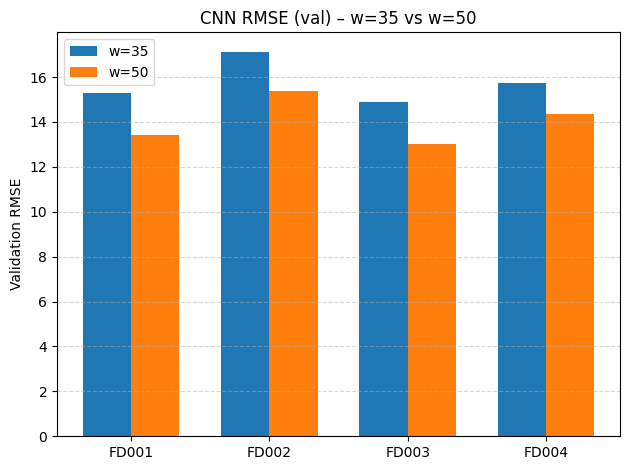

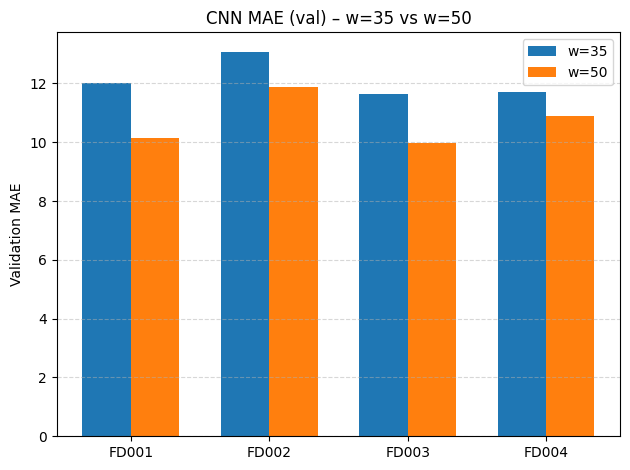

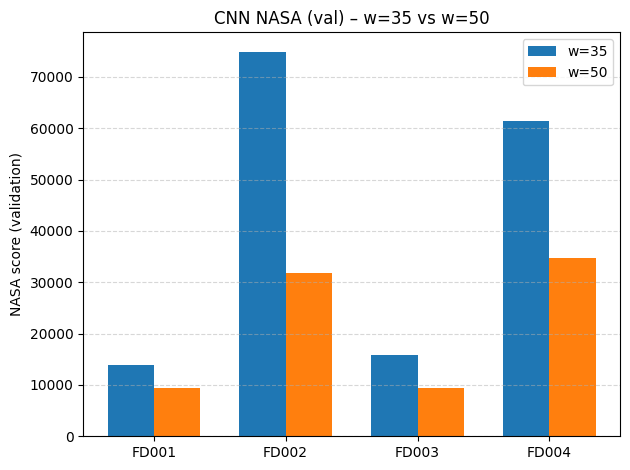

In [12]:
summary_rows = []

for name, best_dict in [
    ("FD001", best_fd001),
    ("FD002", best_fd002),
    ("FD003", best_fd003),
    ("FD004", best_fd004),
]:
    for w in WINDOWS:
        b = best_dict[w]
        summary_rows.append({
            "dataset": name,
            "window": w,
            "best_epoch": b["epoch"],
            "rmse": b["rmse"],
            "mae": b["mae"],
            "mse": b["mse"],
            "nasa": b["nasa"],
        })

cnn_summary = pd.DataFrame(summary_rows)
display(cnn_summary)

# for LSTM comparison
cnn_summary["lstm_rmse"] = None
cnn_summary["lstm_nasa"] = None

# grouped bar chart helper
def plot_metric(metric_name, ylabel):
    pivot = cnn_summary.pivot(index="dataset", columns="window", values=metric_name)
    datasets = pivot.index.tolist()
    windows  = pivot.columns.tolist()
    x = np.arange(len(datasets))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, pivot[35].values, width=width, label="w=35")
    plt.bar(x + width/2, pivot[50].values, width=width, label="w=50")
    plt.xticks(x, datasets)
    plt.ylabel(ylabel)
    plt.title(f"CNN {metric_name.upper()} (val) – w=35 vs w=50")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_metric("rmse", "Validation RMSE")
plot_metric("mae", "Validation MAE")
plot_metric("nasa", "NASA score (validation)")

# 12: training loss curves and validation metric curves

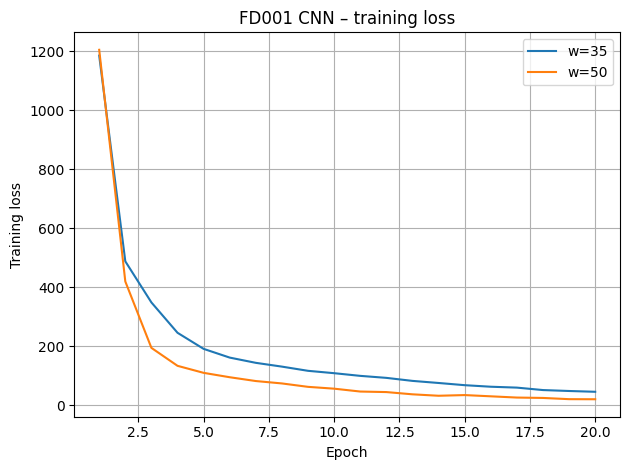

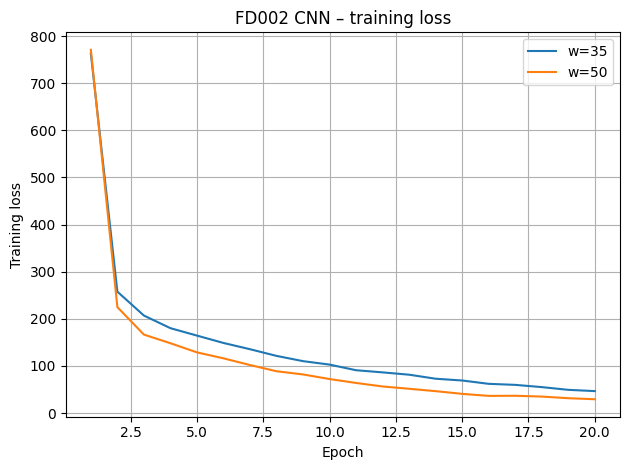

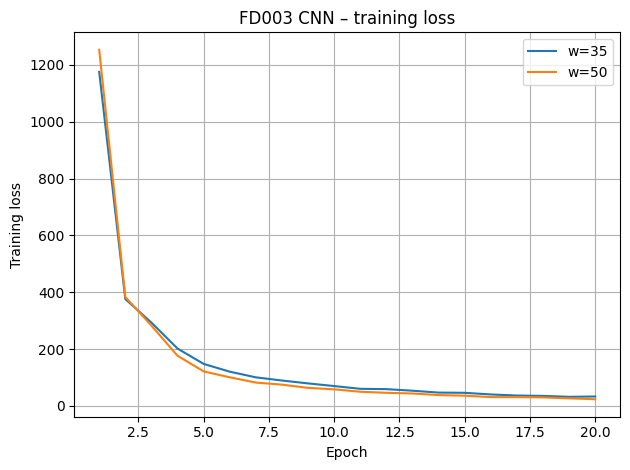

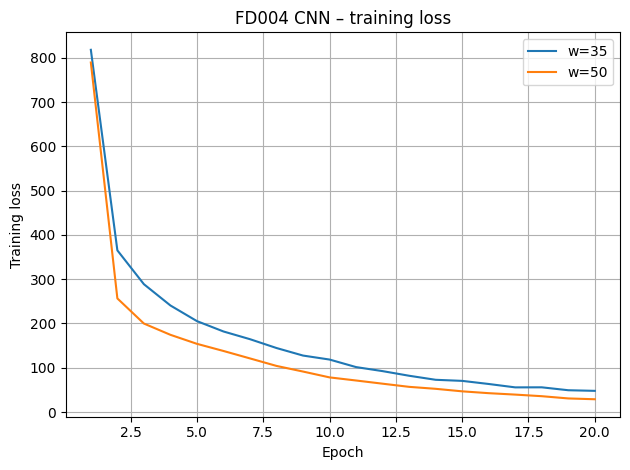

Saved figure to: FD001_rmse.png


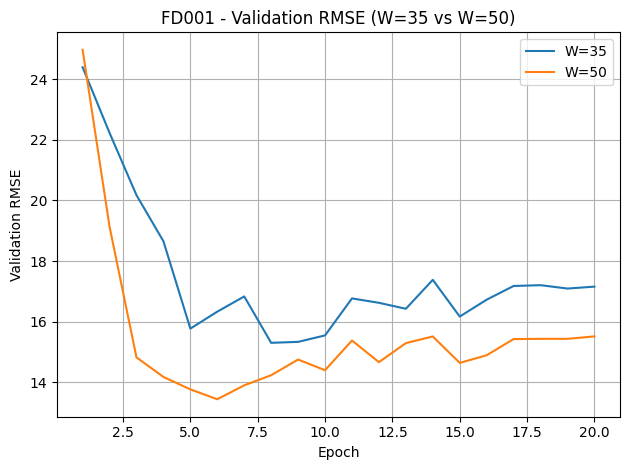

Saved figure to: FD001_mse.png


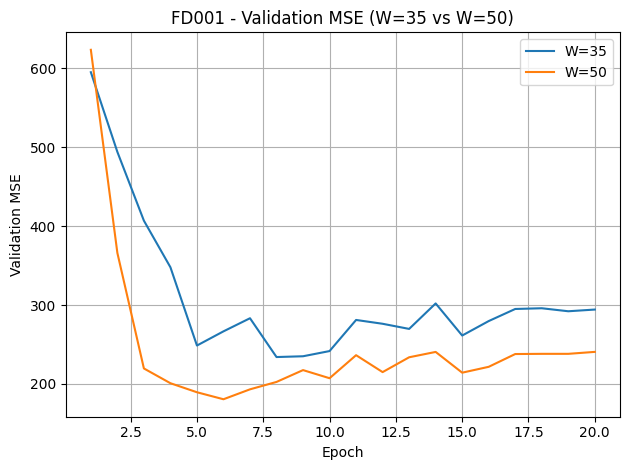

Saved figure to: FD001_nasa.png


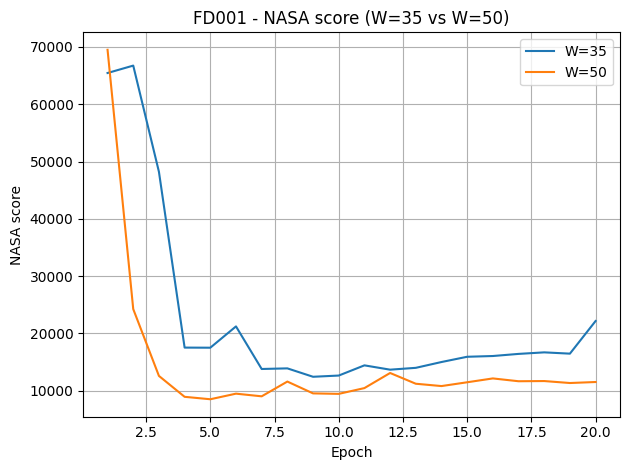

Saved figure to: FD002_rmse.png


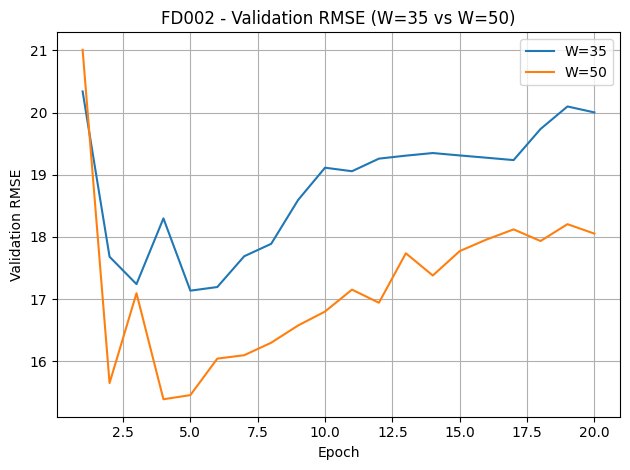

Saved figure to: FD002_mse.png


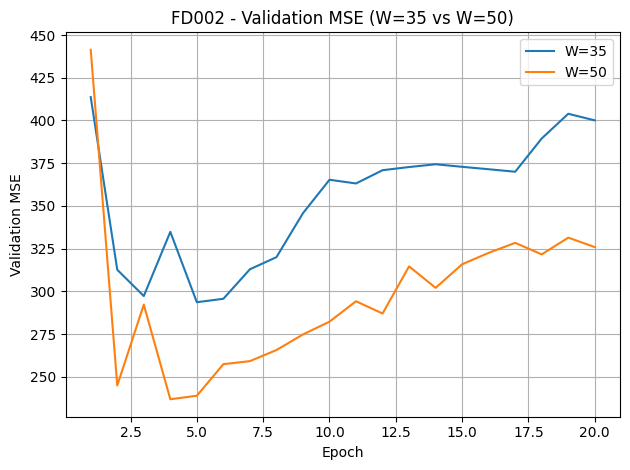

Saved figure to: FD002_nasa.png


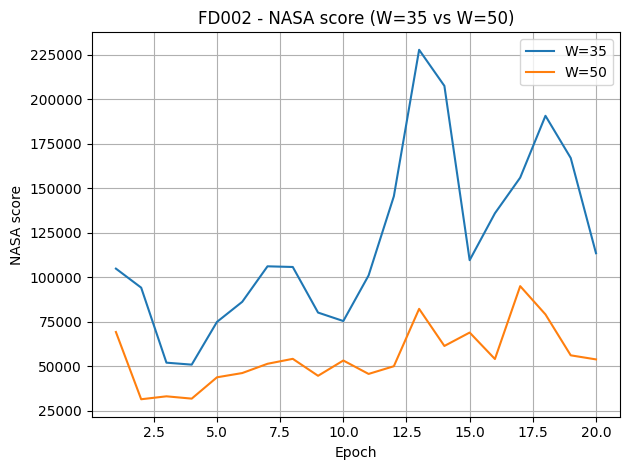

Saved figure to: FD003_rmse.png


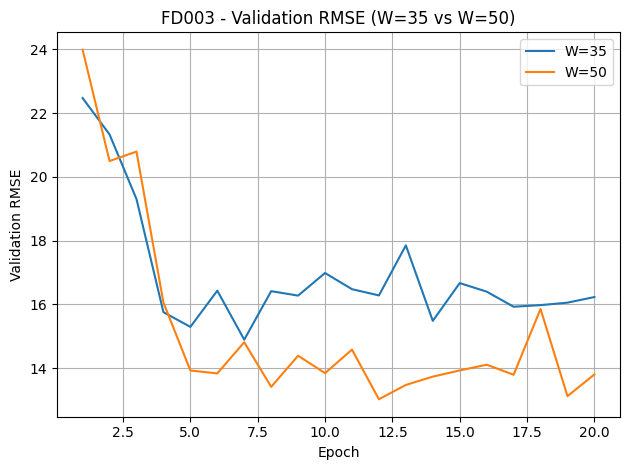

Saved figure to: FD003_mse.png


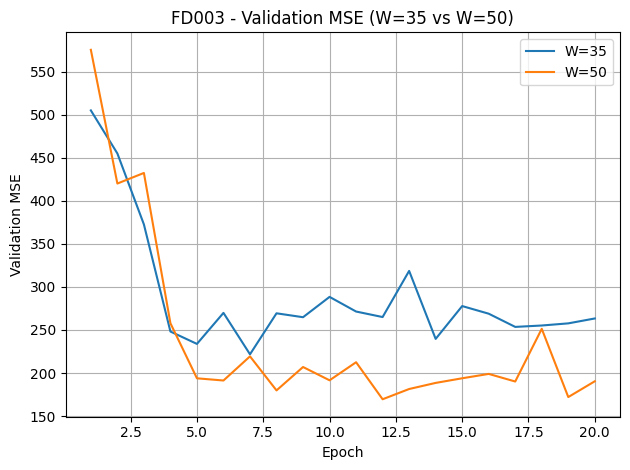

Saved figure to: FD003_nasa.png


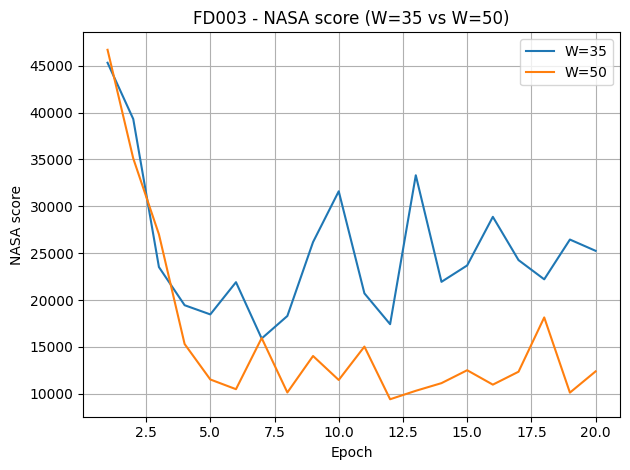

Saved figure to: FD004_rmse.png


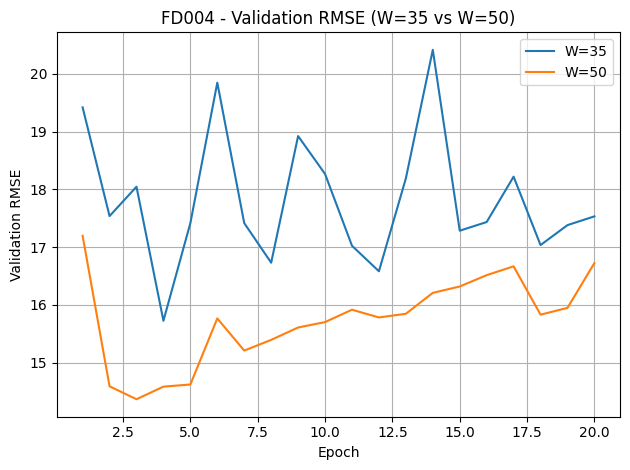

Saved figure to: FD004_mse.png


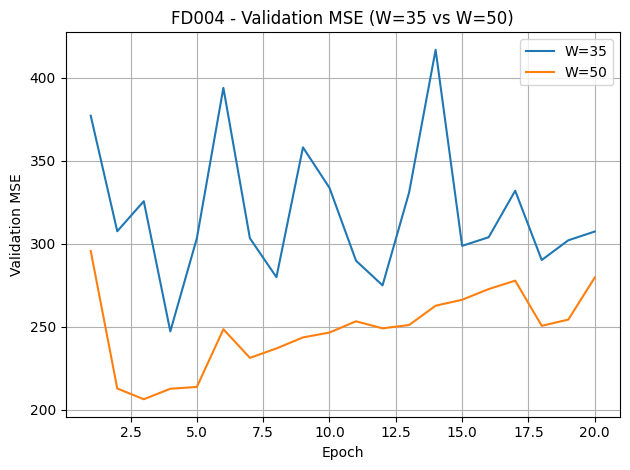

Saved figure to: FD004_nasa.png


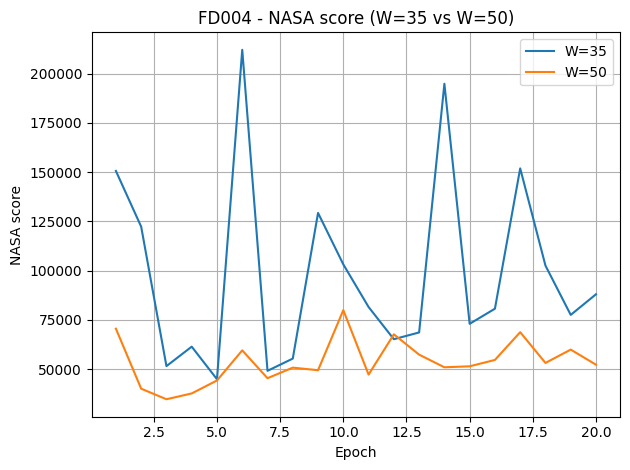

In [13]:
def plot_train_loss(hist_dict, dataset_name):
    df_35 = pd.DataFrame(hist_dict[35])
    df_50 = pd.DataFrame(hist_dict[50])

    plt.figure()
    plt.plot(df_35["epoch"], df_35["train_loss"], label="w=35")
    plt.plot(df_50["epoch"], df_50["train_loss"], label="w=50")
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.title(f"{dataset_name} CNN – training loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for name, hist_dict in [("FD001", hist_fd001),
                        ("FD002", hist_fd002),
                        ("FD003", hist_fd003),
                        ("FD004", hist_fd004)]:
    plot_train_loss(hist_dict, name)


def plot_val_metric(hist_dict, dataset_name, metric_key, metric_label, suffix):
    df_35 = pd.DataFrame(hist_dict[35])
    df_50 = pd.DataFrame(hist_dict[50])

    plt.figure()
    plt.plot(df_35["epoch"], df_35[metric_key], label="W=35")
    plt.plot(df_50["epoch"], df_50[metric_key], label="W=50")

    plt.xlabel("Epoch")
    plt.ylabel(metric_label)
    plt.title(f"{dataset_name} - {metric_label} (W=35 vs W=50)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fname = f"{dataset_name}_{suffix}.png"
    plt.savefig(fname, dpi=200)
    print("Saved figure to:", fname)
    plt.show()

for name, hist_dict in [("FD001", hist_fd001),
                        ("FD002", hist_fd002),
                        ("FD003", hist_fd003),
                        ("FD004", hist_fd004)]:
    plot_val_metric(hist_dict, name, "val_rmse", "Validation RMSE", "rmse")
    plot_val_metric(hist_dict, name, "val_mse",  "Validation MSE",  "mse")
    plot_val_metric(hist_dict, name, "val_nasa", "NASA score",      "nasa")